This notebook prepares for the first level analysis: setting up and examining a General Linear Model that produces response amplitudes for each stimulus class. For this, the data must be preprocessed. We will use GLMdenoise to do this, which is a MATLAB toolbox, and so the actual analysis will be run outside of this notebook (it takes a while and a lot of resources anyway, so this is for the best).

# Creating the design matrix

The first thing we need to do is create our design matrix. Our design matrix needs to be in the format time by conditions (where time is in TRs), with a 1 for condition onset. This will be exceedingly sparse, since each condition only shows up once per run (when we move this into matlab, we will make it a sparse matrix). We will have one of these design matrices per run.

In [15]:
import sys
sys.path.append('..')
import sfp
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import os
%matplotlib inline
from bids.grabbids import BIDSLayout

In [36]:
layout = BIDSLayout("/home/billbrod/Data/spatial_frequency_preferences/")
# This contains all the design information
tsv_df = pd.read_csv(layout.get(type='events', subject='wlsubj001', session='01' ,run=1)[0].filename)

nii_file = layout.get(type='bold', subject='wlsubj001', session='01', run=1)[0].filename
# We need to load in the nifti file so we can determine how many TRs there were
nii = nib.load(nii_file)

We grab the number of TRs from our nifti file.

In [6]:
n_TRs = nii.shape[3]
print("Num TRs: %d" % n_TRs)

Num TRs: 256


In [10]:
tsv_df.head()

,onset,duration,trial_type,stim_file,stim_file_index
0,0.012,0.3,43,pilot01_unshuffled.npy,350
1,0.512,0.3,43,pilot01_unshuffled.npy,349
2,1.012,0.3,43,pilot01_unshuffled.npy,346
3,1.512,0.3,43,pilot01_unshuffled.npy,345
4,2.012,0.3,43,pilot01_unshuffled.npy,351


We also have the onset times of all of our stimuli, as well as an identifying index we can use to look up its information. We constructed  our stimuli in classes, so that each class contains stimuli with all the same frequency parameters (`w_r / w_a` or `w_x / w_y`) and different phases. When constructing the events tsv file, we also saved an index for the stimulus class, which we call `trial_type`.

For constructing the design matrix, we don't care about the individual stimuli that only differ in their phase: our events are the presentations of new stimulus classes / `trial_type`, so we drop all the other stimuli.

In [16]:
design_df = tsv_df.drop_duplicates('trial_type', keep='first')

Now we need to convert these to to TR times. First we find the onset times of TRs, in seconds, relative to the first TR. We then create a giant matrix where each row is a different stimulus onset time and then, in each column, subtract a TR onset time (so this matrix will be `num_conditions x num_TRs`). If we then round this difference-in-time matrix and look for the 0s, we've found what TR onset is closest to the onset of the stimuli. Note that this won't make sense for a lot of entries; some of them start almost exactly halfway through a TR. But, because of how we defined our experiment, our class transitions should happen right around a TR onset (if the timings of the scanner and the stimulus computer were perfect, then they would be exactly the same; as it is they probably differ by a few milliseconds) and so this will work

In [41]:
TR = layout.get_metadata(nii_file)['RepetitionTime']
TR_times = [TR * i for i in range(n_TRs)]

In [42]:
stim_times = design_df['onset'].values
stim_times = np.expand_dims(stim_times,1)
stim_times = np.repeat(stim_times, n_TRs, 1)

In [43]:
time_from_TR = np.round(stim_times - TR_times)
design_df['Onset time (TR)'] = np.where(time_from_TR==0)[1]

/home/billbrod/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


And we create our design matrix, iterate through throw our `design_df` and put a one where each class shows up in a TR.

In [48]:
# because the values are 0-indexed
design_matrix = np.zeros((n_TRs, design_df.trial_type.max()+1))

for i, row in design_df.iterrows():
    row = row[['Onset time (TR)', 'trial_type']].astype(int)
    design_matrix[row['Onset time (TR)'], row['trial_type']] = 1

To make sure things work correctly, we look at our axis sums: each class (axis 1) should show up exactly once and each TR (axis 0) should have 0 or 1 classes in it

In [49]:
print("Each entry represents one of our %d classes:" % design_matrix.shape[1])
print(design_matrix.sum(0))

print("Each entry represents one of our %d TRs:" % design_matrix.shape[0])
print(design_matrix.sum(1))

Each entry represents one of our 52 classes:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
Each entry represents one of our 256 TRs:
[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0

And now we can look at our design matrix for this run!

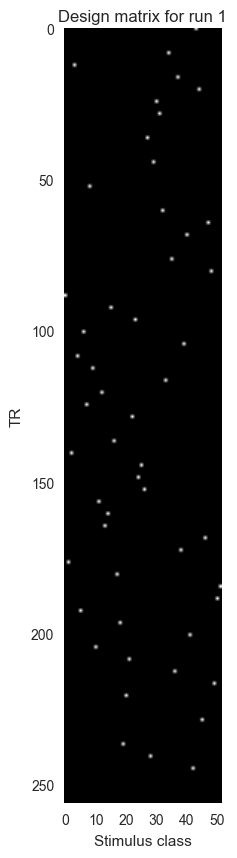

In [55]:
sfp.design_matrices.plot_design_matrix(design_matrix, 'Design matrix for run 1')

The function `sfp.design_matrices.create_all_design_matrices` creates the design matrices for multiple runs and saves them as `.tsv` files so they can be read into matlab.

In order to create them efficiently, run `sfp/design_matrices.py` from the command line (see it's help string for details as to how).

Actually running the first-level analysis requires matlab and should be run on the cluster (see `matlab/runGLM.m`), since they require Kendrick Kay's [GLMdenoise](http://kendrickkay.net/GLMdenoise/) package and use a lot of memory. After you've finished getting the results, examined the $R^2$ values to make sure they make sense, and realigned them to the subject's freesurfer anatomy (using `MRI_tools/preprocessing/to_freesurfer.py`), then you're ready for the next notebook, where we analyze these results.

# Checking the design matrix

We really want to make sure our design matrix is not wrong, as that would screw everything up, so if you're concerned, this is how you double-check everything.

In order to use this, run the first block, which will create pictures, one from each class, in the order the `design_df` thinks they are presented. Then run the next block, containing `sfp.experiment.run`, on a two-monitor setup so one monitor can display the experiment while you have this notebook open in the other. This will allow you to make sure the stimuli are being ordered correctly.

You can also compare `design_df.index.values` to a picture of the design matrix to make sure things got transferred correctly there as well.

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import sys
sys.path.append('..')
from sfp import experiment
import pyPyrTools.JBhelpers as jbh
import os

DATA_DIR = '/home/billbrod/Data/spatial_frequency_preferences/'
layout = BIDSLayout(DATA_DIR)

# This contains all the design information
tsv_df = pd.read_csv(layout.get(type='events', subject='wlsubj001', session='01' ,run=1)[0].filename)

# Load in the appropriate stimuli
stim = np.load(os.path.join(DATA_DIR, 'stimuli/unshuffled.npy'))

# Get the indices for one image from each class so we can loop through them easily
stim_idx = tsv_df.drop_duplicates('trial_type').stim_file_index.values

In [16]:
data = experiment.run(os.path.join('stimuli/unshuffled.npy'), os.path.join(DATA_DIR, 'sourcedata/wl_subj001/20180131/sub-wlsubj001_run00_idx.npy'), None, screen=0)

366.1208 	ERROR 	Unknown colorSpace: None


In [ ]:
jbh.showIm([stim[i,:,:] for i in stim_idx[:10]], ncols=5, zoom=.2)

In [ ]:
jbh.showIm([stim[i,:,:] for i in stim_idx[10:20]], ncols=5, zoom=.2)

In [ ]:
jbh.showIm([stim[i,:,:] for i in stim_idx[20:30]], ncols=5, zoom=.2)

In [ ]:
jbh.showIm([stim[i,:,:] for i in stim_idx[30:40]], ncols=5, zoom=.2)

In [ ]:
jbh.showIm([stim[i,:,:] for i in stim_idx[40:50]], ncols=5, zoom=.2)

In [ ]:
jbh.showIm([stim[i,:,:] for i in stim_idx[50:]], ncols=5, zoom=.2)